In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import warnings
warnings.filterwarnings('ignore')
# make matplotlib pdf-s text recognizable by evil-Adobe
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from more_itertools import chunked
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

In [ ]:
from matplotlib.colors import LogNorm
# https://stackoverflow.com/questions/48625475/python-shifted-logarithmic-colorbar-white-color-offset-to-center
class MidPointLogNorm(LogNorm):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        LogNorm.__init__(self, vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.array(np.interp(np.log(value), x, y), mask=result.mask, copy=False)

### Read some list of BEDPE interactions here

In [4]:
bedpe = pd.read_csv("EP_50-500kb_with_CTCF_status.bedpe",sep="\t")
# fill in some missing bits (without it groupby does not work well):
bedpe.loc[bedpe["strand1"].isnull(),"strand1"] = "."
bedpe.loc[bedpe["strand2"].isnull(),"strand2"] = "."
bedpe.loc[bedpe["between_status"].isnull(),"between_status"] = "none"
# print a piece ofit:
display(bedpe.head(4))
#
PE_groups = bedpe.groupby(by=["type1","strand1","type2","strand2","between_status"])
display(PE_groups.size())

,chrom1,start1,end1,type1,strand1,chrom2,start2,end2,type2,strand2,between_status
0,chr1,762901.0,762902.0,tss,-,chr1,816241.0,817150.0,enhancer,.,ctcf
1,chr1,762901.0,762902.0,tss,-,chr1,969279.0,969493.0,enhancer,.,ctcf
2,chr1,762901.0,762902.0,tss,-,chr1,1014914.0,1015649.0,enhancer,.,ctcf
3,chr1,762970.0,762971.0,tss,+,chr1,816241.0,817150.0,enhancer,.,ctcf


type1     strand1  type2     strand2  between_status
enhancer  .        tss       +        ctcf              7020
                                      none              2584
                             -        ctcf              6676
                                      none              2778
tss       +        enhancer  .        ctcf              6531
                                      none              2958
          -        enhancer  .        ctcf              6647
                                      none              2814
dtype: int64

### Let's read pre-generated coolpup pileups here - for all the mutants/samples ...

In [10]:
# !scp shadow:/data/venevs/ALV-repo/PUP_DICT_5kb_SHIFT_EXP_PromEnhanc.pickle ./
import pickle
fp = open("PUP_DICT_5kb_SHIFT_EXP_PromEnhanc.pickle", "rb")
cpup_ep_dict = pickle.load(fp)
# Save object to file
fp.close()
#
cpup_ep_samples = list(cpup_ep_dict.keys())

In [26]:
list(cpup_ep_dict['PolII-IAA.hg19']["data"].to_dict().keys())

[('enhancer', '.', 'tss', '+', 'ctcf', 'all'),
 ('enhancer', '.', 'tss', '+', 'none', 'all'),
 ('enhancer', '.', 'tss', '-', 'ctcf', 'all'),
 ('enhancer', '.', 'tss', '-', 'none', 'all'),
 ('tss', '+', 'enhancer', '.', 'ctcf', 'all'),
 ('tss', '+', 'enhancer', '.', 'none', 'all'),
 ('tss', '-', 'enhancer', '.', 'ctcf', 'all'),
 ('tss', '-', 'enhancer', '.', 'none', 'all')]

In [18]:
def reverse_strand(strand):
    """
    reverse strand: +->-, -->+, .->.
    """
    if strand == "+":
        return "-"
    elif strand == "-":
        return "+"
    else:
        return strand

def flip_int(int_description):
    """
    flip promoter-enhancer pairs into Enhancer to Promoter
    """
    type1, strand1, type2, strand2, *_bs = int_description
    return type2, reverse_strand(strand2), type1, reverse_strand(strand1), *_bs

def flip_PE(pe_tuple):
    """
    flip promoter-enhancer pairs into Enhancer--Promoter ones
    """
    t1, *_ = pe_tuple
    if t1 != "enhancer":
        return flip_int(pe_tuple)
    else:
        return pe_tuple

In [62]:
import scipy

def get_cpup_hm(sample_name, tss_orientation, ctcf_status, flip45=True ):
    """
    extract cpup pileup from that huge dictionary for a given sample (exp,size)
    and also flip45 if requested ...
    """
    combined_dict = {}
    mean_dict = {}
    _cpup_sample_dict = cpup_ep_dict[sample_name]["data"].to_dict()   
    for k,mat in _cpup_sample_dict.items():
        # flip PE to EP ...
        # if k==invk it's already EP (nothing to flip)
        invk = flip_PE(k)
        # flip corresponding HeatMap if it was PE, keep as is if EP
        invmat = mat[::-1,::-1] if k != invk else mat
        # populate combined_dict now
        if invk not in combined_dict:
            combined_dict[invk] = [ invmat ]
        else:
            combined_dict[invk].append(invmat)
            mean_dict[invk] = np.nanmean(combined_dict[invk],axis=0)
    # returning a particular heatmap that was requested ...
    # template: ('enhancer', '.', 'tss', '+', 'ctcf', 'all')
    hm_average = mean_dict[("enhancer",".","tss",tss_orientation,ctcf_status,"all")]
    # flipping if needed ...
    if not flip45:
        return hm_average
    else:
        # fill NaNs with 1.0 (obs==exp), otherwise flipping 45 breaks ...
        hm_average = np.nan_to_num(hm_average, nan=1.)
        _hm = scipy.ndimage.rotate(hm_average,45,cval=np.nan,reshape=True)
        l,w = _hm.shape
        half_l = l//2
        # removing upper pic spitz vershina "verh == up"
        pic_hide = int(0.33*half_l)
        return _hm[pic_hide:half_l,:]

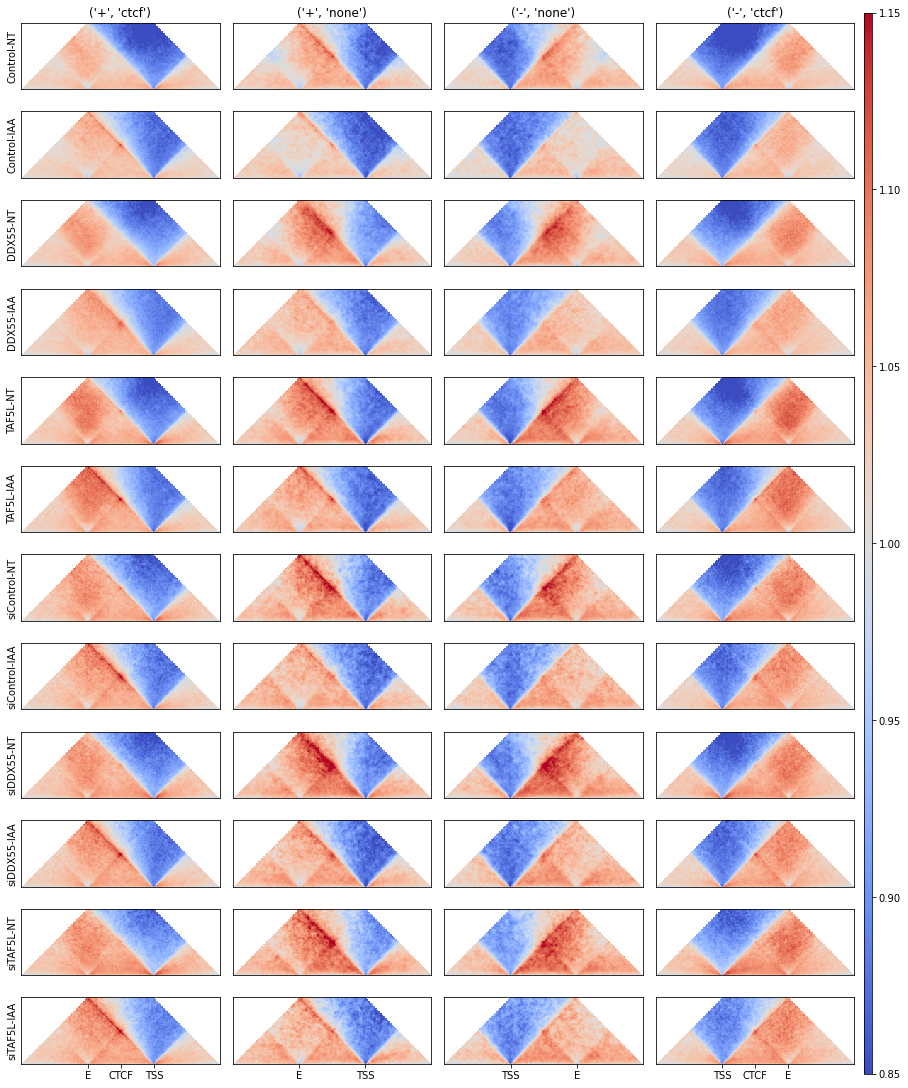

In [104]:
fig = plt.figure(figsize = (12.5,15), constrained_layout=True)

suppfig7_samples = ['mutControl-NT.hg19', 'mutControl-IAA.hg19', 
                    'mutDDX55-NT.hg19', 'mutDDX55-IAA.hg19',
                    'mutTAF5L-NT.hg19', 'mutTAF5L-IAA.hg19',
                    'siControl-NT.hg19', 'siControl-IAA.hg19',
                    'siDDX55-NT.hg19', 'siDDX55-IAA.hg19', 
                    'siTAF5L-NT.hg19', 'siTAF5L-IAA.hg19', 
                   ]

# suppfig7_samples = ['mutControl-NT.hg19',
#                     'mutDDX55-NT.hg19',
#                     'mutTAF5L-NT.hg19',
#                     'siControl-NT.hg19',
#                     'siDDX55-NT.hg19',
#                     'siTAF5L-NT.hg19',
#                     'mutControl-IAA.hg19', 
#                     'mutDDX55-IAA.hg19',
#                     'mutTAF5L-IAA.hg19',
#                     'siControl-IAA.hg19',
#                     'siDDX55-IAA.hg19', 
#                     'siTAF5L-IAA.hg19', 
#                    ]
# suppfig7_samples = ['mutControl-NT.hg19',
# #                     'mutDDX55-NT.hg19',
#                     'mutTAF5L-NT.hg19',
#                     'siControl-NT.hg19',
# #                     'siDDX55-NT.hg19',
#                     'siTAF5L-NT.hg19',
#                     'mutControl-IAA.hg19', 
# #                     'mutDDX55-IAA.hg19',
#                     'mutTAF5L-IAA.hg19',
#                     'siControl-IAA.hg19',
# #                     'siDDX55-IAA.hg19', 
#                     'siTAF5L-IAA.hg19', 
#                    ]

gs = fig.add_gridspec(len(suppfig7_samples),4+1,width_ratios=[1,1,1,1,0.04])

# let's just do the coolpupping along the way ...
for row_id, cpup_sample in enumerate(suppfig7_samples):
    for col_id, (tss_strand,ctcf_status) in enumerate([("+", "ctcf"),
                                            ("+", "none"),
                                            ("-", "none"),
                                            ("-", "ctcf")]):
        # coolpupping along the way ...
        ax = fig.add_subplot(gs[row_id, col_id])
        hhh = get_cpup_hm(cpup_sample, tss_strand, ctcf_status, flip45=True )
        if tss_strand == "-":
            hhh = hhh[:,::-1]
        cl = plt.imshow(hhh,
                        interpolation="none",
                        cmap="coolwarm",
                        norm = colors.TwoSlopeNorm(vmin=0.85,vcenter=1, vmax=1.15)
                       )
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_yticklabels([])
        if row_id == 0:
            ax.set_title( (tss_strand,ctcf_status) )
        if col_id == 0:
            ax.set_ylabel(cpup_sample.rstrip(".hg19").lstrip("mut"))
        if row_id == len(suppfig7_samples)-1:
            _,w = hhh.shape
            if ctcf_status == "ctcf":
                ax.set_xticks([w/3,w/2,2*w/3])
                ax.set_xticklabels(["E","CTCF","TSS"] if tss_strand=="+" else ["TSS","CTCF","E"])
            else:
                ax.set_xticks([w/3,2*w/3])
                ax.set_xticklabels(["E","TSS"] if tss_strand=="+" else ["TSS","E"])

        
# right side color bar
ax = fig.add_subplot(gs[:,-1])
bar = plt.colorbar(cl, cax=ax, orientation="vertical")


plt.savefig("SuppFigure7_mut-siRNA_clustered.pdf")

In [108]:
# ! scp SuppFigure7_*_clustered.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

SuppFigure7_mut-siRNA_clustered.pdf           100% 1823KB 339.8KB/s   00:05    
SuppFigure7_NT-IAA_clustered.pdf              100% 1823KB 444.9KB/s   00:04    
